##얼굴인식 스티커앱 만들기: png 파일을 사용하여 얼굴 사진 위에 고양이 스티커 사진을 붙이기  
전체 과정  
1. 사진 준비하기  
2. face detection  
3. face landmark  
4. 스티커 적용  

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

In [3]:
#파일경로설정
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/20220111_124937_204.png'

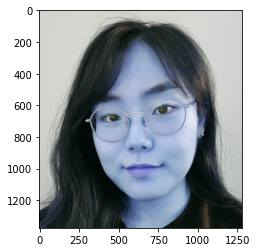

In [4]:
#opencv로 사진 불러오기 
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() #출력용 이미지 별도 저장 
plt.imshow(img_bgr)
plt.show()

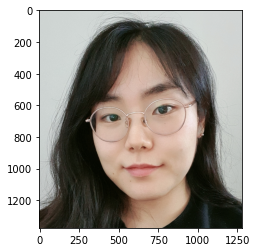

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #RGB로 바꾸기
plt.imshow(img_rgb)
plt.show()

In [6]:
#detector 선언  
detector_hog = dlib.get_frontal_face_detector()

#얼굴 bounding box 추출
dlib_rects = detector_hog(img_rgb, 1) #detector_hog(image, num of image pyramid)

<b>HOG:</b> 이미지에서 색상의 변화량을 계산해 대상의 특징만 잡아냄  
<b>sliding window:</b> 작은 영역(window)을 이동해가며 확인하는 방법, 이미지가 클수록 오래걸리는 단점 있음  
<b>dlib:</b>rgb 이미지 입력받음  
image pyramid: 원본 이미지의 다양한 사이즈로 부터 얼굴 찾아냄, 가장 아래에 큰 해상도 위로 갈수록 해상도 줄여가면서 쌓아가는 형태  

rectangles[[(248, 426) (1046, 1224)]]
[(248, 426) (1046, 1224)]


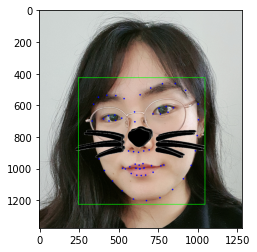

In [78]:
#찾은 얼굴 영역 박스 리스트 
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l, t), (r, b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

<b>face landmark</b>  
object keypoint estimation 알고리즘: top-down 방식사용.  
즉, bounding box를 찾고 box 내부의 keypoint 예측  

In [47]:
#저장한 landmark 모델 불러옴
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [87]:
#dlib.full_object_detection 반환
list_landmarks = []

#얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) #RGB 이미지, dlib.rectangle입력받음 
    #face landmark 좌표를 저장해둠  
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


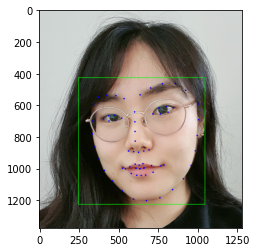

In [49]:
#랜드마크 영상에 출력, 노란색은 잘 안보여서 파란색으로 변경 
blue_color = (255, 0, 0)
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, blue_color, 5)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

<b>스티커 위치 정하기</b>  
정면 사진이고 스티커 사진의 크기와 face detection 크기가 동일하므로 코의 위치를 기준으로 x, y 좌표를 구해주고 위의 dlib_rects의 rectangles[[(248, 426) (1046, 1224)]]에서 refined_x, refined_y를 (248, 426)으로 맞추고 조금씩 조정해줬다.   


In [50]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print("코의 위치: ", landmark[30]) #코의 index = 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print('(x,y) : (%d,%d)'%(x,y))
    print('(w,h) : (%d,%d)'%(w,h))

코의 위치:  (606, 826)
(x,y) : (606,427)
(w,h) : (799,799)


In [51]:
#스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2 .resize(img_sticker, (w,h))
print(img_sticker.shape)

(799, 799, 3)


In [72]:
#원본 이미지에 스티커 이미지를 추가하기 위한 x,y 좌표 조정 
refined_x = 230
refined_y = 440
print('(x,y) : (%d,%d)'%(refined_x, refined_y)) #스티커의 시작점이 사진을 벗어나면 음수로 표현됨

(x,y) : (230,440)


In [73]:
#ndarray는 음수 인덱스에 접근할 수 없기 때문에 이미지의 시작점이 얼굴 사진의 영역을 벗어났을 경우 예외 처리 과정
#if refined_x < 0:
#    img_sticker = img_sticker[:, -refined_x:]
#    refined_x = 0
#if refined_y < 0:
#    img_sticker = img_sticker[-refined_y:, :]
#    refined_y = 0
    
#print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (230,440)


In [79]:
#스티커 사진의 검은색 영역을 사용하므로 img_sticker=255로 지정 
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) #np.where:img_sticker=0인 부분 stick_area 사용,

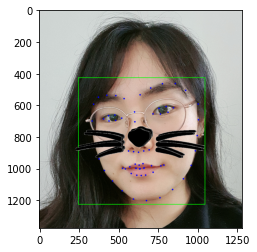

In [80]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

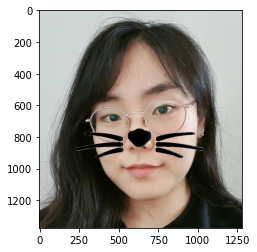

In [81]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

##아이유 사진에 고양이 수염 스티커 올리기  

In [209]:
#파일
iu_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/iu.png'

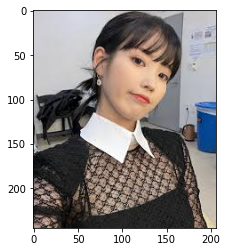

In [210]:
#wendy사진 불러오고 rgb로 바꾸기 
iu_img_bgr = cv2.imread(iu_image_path)
iu_img_show = iu_img_bgr.copy() 
iu_img_rgb = cv2.cvtColor(iu_img_bgr, cv2.COLOR_BGR2RGB) 
plt.imshow(iu_img_rgb)
plt.show()

In [211]:
#detector 선언  
iu_detector_hog = dlib.get_frontal_face_detector()

#얼굴 bounding box 추출
iu_dlib_rects = iu_detector_hog(iu_img_rgb, 1) 

rectangles[[(86, 26) (175, 116)]]


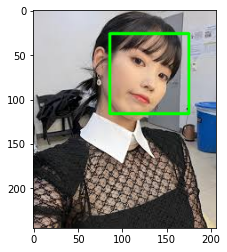

In [212]:
#찾은 얼굴 영역 박스 리스트 
print(iu_dlib_rects)

for dlib_rect in iu_dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(iu_img_show, (l, t), (r, b), (0,255,0), 2, lineType=cv2.LINE_AA)

iu_img_show_rgb = cv2.cvtColor(iu_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(iu_img_show_rgb)
plt.show()

In [213]:
#저장한 landmark 모델 불러옴
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [214]:
#dlib.full_object_detection 반환
iu_list_landmarks = []

#얼굴 영역 박스 마다 face landmark를 찾아냄
for dlib_rect in iu_dlib_rects:
    points = landmark_predictor(iu_img_rgb, dlib_rect) #RGB 이미지, dlib.rectangle입력받음 
    #face landmark 좌표를 저장해둠  
    iu_list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    iu_list_landmarks.append(iu_list_points)
    
print(len(iu_list_landmarks[0]))

68


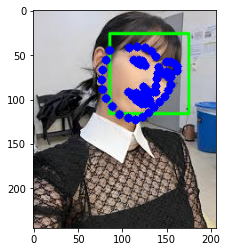

In [215]:
#랜드마크 영상에 출력, 노란색은 잘 안보여서 파란색으로 변경 
blue_color = (255, 0, 0)
for landmark in iu_list_landmarks:
    for point in landmark:
        cv2.circle(iu_img_show, point, 2, blue_color, 5)
        
iu_img_show_rgb = cv2.cvtColor(iu_img_show, cv2.COLOR_BGR2RGB)
plt.imshow(iu_img_show_rgb)
plt.show()

In [216]:
for dlib_rect, landmark in zip(iu_dlib_rects, iu_list_landmarks):
    print("코의 위치: ", landmark[30]) #코의 index = 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print('(x,y) : (%d,%d)'%(x,y))
    print('(w,h) : (%d,%d)'%(w,h))

코의 위치:  (138, 85)
(x,y) : (138,40)
(w,h) : (90,90)


In [217]:
#스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2 .resize(img_sticker, (w,h))
print(img_sticker.shape)

(90, 90, 3)


tangent를 활용한 스티커 회전을 위한 각도 구하기
코 위치 30과 눈썹쪽 위치 23를 이용  
tanθ = (x_30 - y_23) / (y_30 - y_23) 
각도 °= θ*(180/π)  
getRotationMatrix2D를 이용해 이미지 회전 변환 매트릭스 만들어줌 => 반시계방향으로 각도 증가하므로 오른쪽으로 얼굴이 기울어진 해당 사진에는 음수 값나옴   
참고 블로그:https://velog.io/@dldndyd01/OpenCV-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%EC%A4%91%EC%95%99-%EA%B8%B0%EC%A4%80-%ED%9A%8C%EC%A0%84-cv2.getRotationMatrix2D-%EC%96%BC%EA%B5%B4-%ED%9A%8C%EC%A0%84-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0  

In [218]:
import math
tan_theta = (landmark[30][0]-landmark[23][0])/(landmark[30][1]-landmark[23][1])
theta = np.arctan(tan_theta) #역삼각함수 아크탄젠트 값 (inverse trigonometric tangent)을 반환
rotate_angle = theta *180/math.pi #theta를 각도로 변환
print(rotate_angle)

-32.19573393471325


(90, 90, 3)


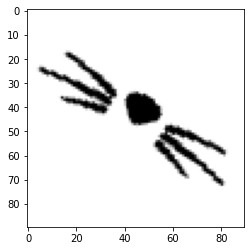

In [219]:
#이미지 회전시켜주는 함수
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0) #이미지 해당 각도 만큼 회전
  #warpAffine:이미지 이동      
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
  return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape) #이미지 크기 출력 
plt.imshow(img_rotate)
plt.show()

In [220]:
#스티커 위치 조정 
refined_x = x - w//2 - 10
refined_y = y

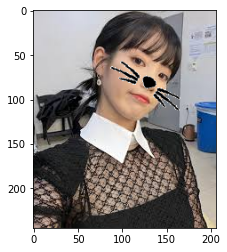

In [221]:
sticker_area = iu_img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]]
iu_img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(iu_img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

##Discussion  
1. 얼굴이 정면에 있으면 스티커 합성하기가 쉬웠는데 얼굴의 각도가 기울어진 경우 생각할 거리가 더 많았다. 먼저 각도를 구하는 공식을 선택한 다음 값을 구하고 스티커 사진을 각도 만큼 회전을 시켜줘야했다.  
또한 refined_x, refined_y를 구할 때 공식을 적용하면 대략적인 위치는 맞으나 내가 원하는 위치에 정확히 스티커를 합성하기 위해서는 미세한 조정이 필요했다. 여기서 스티커 앱의 문제점이 발생할거라 생각한다. 다양한 사진은 각각 크기가 달라 공식을 통해 스티커의 위치를 정해도 정확도를 위한 약간의 조정은 필요하기 때문이다. 나의 경우도 refined_x = x - w//2 공식에서 -10을 추가해줘야 코 위에 정확하게 스티커가 합성됐다.  
3. 여기서 사용하지 않았지만 멀리서 촬영한 사진은 bounding box가 작은 크기이고 그 만큼 landmark도 촘촘히 찍히기 때문에 스티커 위치 조정하기 어려울 것 같다.  
4. 실행 속도는 고정된 이미지에는 크게 중요하다고 생각하진 않지만 움직이는 물체에 스티커를 입힐 때는 중요할 것 같다.   